In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/')
import os

# TODO: Fill in the Google Drive path where you uploaded the files 
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab/final_project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['COVID_combined', 'Normal', 'maskHE2_labels.csv', 'test', 'validation', 'ReadMe.gdoc', 'training.ipynb', 'training', 'train_dataset.npy', 'valid_dataset.npy', 'train_dataset_jiahong.npy', 'valid_dataset_jiahong.npy', 'Model_LungSegmentation', 'Model_Without_Lungseg', 'images_nomask', 'HE_output2.zip', 'Things to be done for Final Project.gdoc', 'Siamese_Learning.ipynb', 'grad_labels.csv', 'Matching_code', 'val_labels.csv', 'test_labels.csv', 'train_labels.csv', 'Copy of Siamese_Learning.ipynb', 'COVID-19 X-Ray Image Classification Using Transfer Learning and Contrastive Learning.gslides', 'Training_VGG16_CrossValidation_WithLungMasking.ipynb', 'grad_labels_4.csv', 'grad_labels_new.csv', 'create_label.ipynb']


In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image

import copy

torch.cuda.empty_cache()

**Transform dataset- Data Augmentation**

In [5]:
train_transforms = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.CenterCrop(224),   #I thing CenterCrop makes more sense than randomCrop, because the lung is ususally at the center of the image
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  #used for data augmentation

val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

grad_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_csv = os.path.join(GOOGLE_DRIVE_PATH,'train_labels.csv')
val_csv = os.path.join(GOOGLE_DRIVE_PATH,'val_labels.csv')
test_csv = os.path.join(GOOGLE_DRIVE_PATH,'test_labels.csv')
grad_csv = os.path.join(GOOGLE_DRIVE_PATH,'grad_labels_new.csv')

class_numbers = 2

COVID_path = os.path.join(GOOGLE_DRIVE_PATH,"images_nomask/COVID")
Normal_path = os.path.join(GOOGLE_DRIVE_PATH,"images_nomask/Normal")

batch_size = 32

In [ ]:
grad_csv

'drive/My Drive/Colab/final_project/grad_labels.csv'

**adding the Kfold**

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [8]:
train_df1 = pd.read_csv(train_csv)
train_df2 = pd.read_csv(val_csv)
train_df=train_df2.append(train_df1,ignore_index=True,sort=True)
#print(train_df)

test_df = pd.read_csv(test_csv)

grad_df_4= pd.read_csv(grad_csv)
print(grad_df_4)

# grad_df_4 = grad_df.iloc[[0,1,4,5],:]
# print(grad_df_4)

            Images  labels  encoded_labels
0   COVID-1343.png   COVID               0
1    COVID-884.png   COVID               0
2   Normal-468.png  NORMAL               1
3  Normal-2619.png  NORMAL               1


In [ ]:
train_features=train_df['Images']
train_target=train_df['encoded_labels']
n_splits = 10 # Number of K-fold Splits

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(train_features, train_target))
#splits

In [9]:
class CovidDataset_Train(Dataset):  # 0 stands for Covid and 1 stands for Normal

  def __init__(self, pandas_file,root_dir1, root_dir,transform=None):
    self.XRay_image = pandas_file
    self.root_dir = root_dir
    self.root_dir1 = root_dir1
    self.transform = transform

  def __len__(self):
    return len(self.XRay_image)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name1 = os.path.join(self.root_dir, self.XRay_image.iloc[idx,0])
        img_name2 = os.path.join(self.root_dir1, self.XRay_image.iloc[idx,0])
        if os.path.exists(img_name1):
          true_name=img_name1
        else:
          true_name=img_name2

        image = io.imread(true_name) # the origial image has 3 channels
        #print(image.shape)
        #image = np.expand_dims(image,axis = 2) #(512,512) but the input of VGG should have three channels
        #image = np.repeat(image, 3, axis=2) #(512, 512, 3)

        image = Image.fromarray(image, 'RGB') # change to PIL image inorder to use transformation
        label = int(self.XRay_image.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        sample = (image, label)
        return sample

**Load trained VGG16**

In [10]:
class_numbers = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16= models.vgg16(pretrained=True)

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer

features.extend([nn.Linear(num_features, class_numbers)]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

vgg16 = vgg16.to(device)

print(vgg16)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [11]:
params_to_update = []
for name,param in vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [12]:
vgg16.load_state_dict(torch.load(GOOGLE_DRIVE_PATH+'Model_Without_Lungseg/VGG16_Cross_Validation_noSegmentation.pt',map_location=torch.device('cpu')))
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Grad-CAM2**

In [13]:
#load test data
Label=grad_df_4['encoded_labels'].to_numpy()
pandas_file=grad_df_4['Images'].to_numpy()
Grad_Final_pd=pd.DataFrame({'x':pandas_file,'y':Label})
Grad_loader=CovidDataset_Train(pandas_file=Grad_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=grad_transforms)
grad_dataloader = torch.utils.data.DataLoader(Grad_loader, batch_size = 1, shuffle=False)

dataloader_iter = iter(grad_dataloader)


In [14]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
  
class SaveGradients():
    features=None
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, grad_input, grad_output):
        self.features = ((grad_output[0].detach().cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

#final_layer = model_ft._modules.get('features')[10]['denselayer16']  #get the layer of features ->denseblock4 ->denselayer16

final_layer = vgg16._modules.get('features')[29] #get the layer before fc 
print(final_layer)
activated_features = SaveFeatures(final_layer)
activated_gradients = SaveGradients(final_layer)

ReLU(inplace=True)


In [15]:
def cam_img(feature_map, grads):
    _, nc, h, w = feature_map.shape
    cam = np.zeros((h,w), dtype=np.float32)	
    #print(cam.shape)
    grads = grads[0]
    #print(grads.shape)	
    weights = np.mean(grads, axis=(1,2))
    #print(weights.shape)
    for i, w in enumerate(weights):
        cam += w * feature_map[0, i, :, :]
    #print(cam.shape)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam


In [16]:
model_ft = vgg16

proba = []
heatmaps = []
original_images = []
predict_labels = []
gt_labels = []

for i in range(4):
  img, labels = next(dataloader_iter)
  img = img.to(device)

  #forward
  output = model_ft(img)
  probabilities = F.softmax(output,dim=1).data.squeeze()
  proba.append((str(np.round(np.max(probabilities.cpu().detach().numpy())*100,2)))+'%')

  pred_idx = np.argmax(probabilities.cpu().detach().numpy(),axis=0)
  predict_labels.append(pred_idx)
  gt_labels.append(labels)

  cur_image = img.cpu().numpy().transpose((0, 2, 3, 1))
  #print(cur_image.shape)
  original_images.append(cur_image)

  # backward
  model_ft.zero_grad()
  class_loss = output[0,pred_idx]
  class_loss.backward()

  #print(activated_features.features.shape)
  #print(activated_gradients.features.shape)

  grad_img = cam_img(activated_features.features, activated_gradients.features)
  #activated_features.remove()
  heatmaps.append(grad_img)
    
print(len(proba), len(heatmaps),len(predict_labels))
print(proba)
print(predict_labels)
print(gt_labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


4 4 4
['99.79%', '90.47%', '99.99%', '79.91%']
[0, 0, 1, 1]
[tensor([0]), tensor([0]), tensor([1]), tensor([1])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


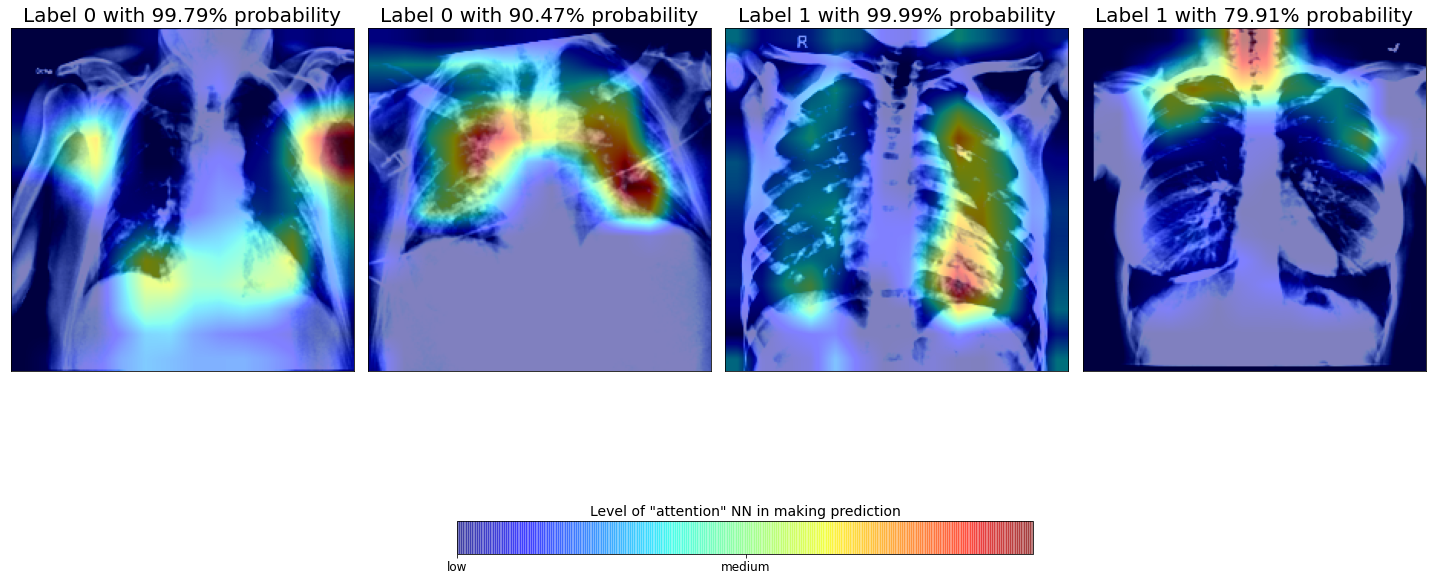

In [17]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
fig=plt.figure(figsize=(20,15))


for i in range(0, len(original_images)):
    img = original_images[i]
    mask = heatmaps[i]
    ax = fig.add_subplot(2, 4,i +1,xticks=[], yticks=[])
    fig.tight_layout()
    plt.imshow(img[0,:,:,:])
    plt.imshow(cv2.resize(mask, (224,224), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet');
    ax.set_title('Label %d with %s probability' % (predict_labels[i], proba[i]),fontsize=20)
    #ax.set_title('Label %d ' % (predict_labels[i]),fontsize=12)
    
#cax = fig.add_axes([0.3, 0.42, 0.4, 0.04]) # place where be map
cax = fig.add_axes([0.32, 0.42, 0.4, 0.03]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=14)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=12)

plt.show()